In [7]:
# Biến chung sử dụng xuyên suốt
import os
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import sys
import math
sys.path.append('P:/7. User/Tuong')
from DB_ALL import SQL_NLTT_NOIBO, Database_TTD

# Cấu hình chung
PATH = r"Z:\Sky-image\Data"  # Đường dẫn ảnh gốc
OUTPUT_DIR = r"C:\Khue\H9_Solar_Power_Forecasting\references\image_out"  # Thư mục lưu ảnh đã xử lý
START_DATE = datetime.datetime(2025, 1, 1)
END_DATE = datetime.datetime(2025, 1, 10)
PLOT_START = datetime.datetime(2025, 1, 3)
PLOT_END = datetime.datetime(2025, 1, 10)
IMG_SIZE_PROCESS = (256, 256)  # Kích thước ảnh khi xử lý ban đầu
IMG_SIZE_MODEL = (32, 32)  # Kích thước ảnh đầu vào mô hình
SEQ_LENGTH = 6  # Độ dài chuỗi đầu vào
PRED_LENGTH = 6  # Độ dài dự đoán
CHANNELS_4 = ['b07_', 'b13_', 'b08_', 'b03_']
CHANNELS = ['b07_', 'b13_', 'b08_', 'b03_', 'arm', 'cve', 'dms', 'dnc', 'dsl', 'dst', 'irv', 'ngt', 'snd', 'tre', 'trm', 'vir']
# CHANNELS = ['arm', 'cve', 'dms', 'dnc', 'dsl', 'dst', 'irv', 'ngt', 'snd', 'tre', 'trm', 'vir']
NUM_CHANNELS = len(CHANNELS)
BATCH_SIZE = 64
TIME_STEP = datetime.timedelta(minutes=10)
UTC_OFFSET = datetime.timedelta(hours=7)

# Khởi tạo scaler toàn cục
scaler = MinMaxScaler()

In [ ]:
# %% Cell 2: Xử lý dữ liệu công suất với sin/cos encoding hoàn chỉnh
def query_power_data(start_date, end_date):
    print("🔄 Đang load dữ liệu công suất...")
    db = SQL_NLTT_NOIBO()
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    df = pd.DataFrame.from_records(db.query(f"""
        SELECT a.THOIDIEM_THUTHAP, a.CONGSUAT_KHOIPHUC as P_uoc
        FROM DB_DGM.dbo.NLTT_UOCTINH_CONGSUAT a
        INNER JOIN DB_DGM.dbo.NLTT_NHAMAY b ON a.ID_NM = b.ID_NM 
        WHERE a.THOIDIEM_THUTHAP >= '{start_date_str}' 
        AND a.THOIDIEM_THUTHAP < '{end_date_str}' 
        AND b.ID_LOAIHINH = 9
        AND a.ID_NM = 353
        ORDER BY a.THOIDIEM_THUTHAP
    """), columns=['NGAY', 'P'])

    # Đổi tên cột và xử lý thời gian
    df.rename(columns={"P": "P_uoc"}, inplace=True)
    df = df.set_index("NGAY").resample('10T').mean()
    power_df = df.reset_index()
    power_df.rename(columns={"NGAY": "Time"}, inplace=True)

    # Tách các thành phần thời gian
    power_df['Month'] = power_df['Time'].dt.month
    power_df['Day'] = power_df['Time'].dt.day
    power_df['Hour'] = power_df['Time'].dt.hour
    power_df['Minute'] = power_df['Time'].dt.minute
    power_df['DaysInMonth'] = power_df['Time'].dt.days_in_month

    # Tính tỷ lệ ngày trong tháng
    power_df['Day_frac'] = power_df['Day'] / power_df['DaysInMonth']

    # Sin/Cos Encoding
    power_df['Month_sin'] = np.sin(2 * np.pi * power_df['Month'] / 12)
    power_df['Month_cos'] = np.cos(2 * np.pi * power_df['Month'] / 12)
    power_df['Day_sin'] = np.sin(2 * np.pi * power_df['Day_frac'])
    power_df['Day_cos'] = np.cos(2 * np.pi * power_df['Day_frac'])
    power_df['Hour_sin'] = np.sin(2 * np.pi * power_df['Hour'] / 24)
    power_df['Hour_cos'] = np.cos(2 * np.pi * power_df['Hour'] / 24)
    power_df['Minute_sin'] = np.sin(2 * np.pi * power_df['Minute'] / 60)
    power_df['Minute_cos'] = np.cos(2 * np.pi * power_df['Minute'] / 60)

    # Giữ lại các cột cần thiết, theo thứ tự rõ ràng
    power_df = power_df[[
        'Time',
        'Month_sin', 'Month_cos',
        'Day_sin', 'Day_cos',
        'Hour_sin', 'Hour_cos',
        'Minute_sin', 'Minute_cos',
        'P_uoc'
    ]]

    # Fit scaler với công suất (chuẩn hóa)
    scaler.fit(power_df[['P_uoc']].dropna())

    # Tạo dictionary lookup
    power_lookup = {}
    for _, row in power_df.iterrows():
        dt = row['Time']
        power_lookup[dt] = {col: row[col] for col in power_df.columns if col != 'Time'}

    print(f"✅ Đã load {len(power_df)} bản ghi")
    print("Dữ liệu mẫu:", power_df.head())
    print("Lookup mẫu:", {k.strftime('%Y-%m-%d %H:%M'): power_lookup[k] for k in list(power_lookup.keys())[:2]})
    return power_df, power_lookup, scaler

# Truy vấn dữ liệu toàn cục
power_df, power_lookup, scaler = query_power_data(START_DATE - TIME_STEP * SEQ_LENGTH, END_DATE + TIME_STEP * PRED_LENGTH)


🔄 Đang load dữ liệu công suất...
✅ Đã load 1440 bản ghi
Dữ liệu mẫu:                  Time     Month_sin  Month_cos       Day_sin  Day_cos  \
0 2024-12-31 00:00:00 -2.449294e-16        1.0 -2.449294e-16      1.0   
1 2024-12-31 00:10:00 -2.449294e-16        1.0 -2.449294e-16      1.0   
2 2024-12-31 00:20:00 -2.449294e-16        1.0 -2.449294e-16      1.0   
3 2024-12-31 00:30:00 -2.449294e-16        1.0 -2.449294e-16      1.0   
4 2024-12-31 00:40:00 -2.449294e-16        1.0 -2.449294e-16      1.0   

   Hour_sin  Hour_cos    Minute_sin  Minute_cos  P_uoc  
0       0.0       1.0  0.000000e+00         1.0    0.0  
1       0.0       1.0  8.660254e-01         0.5    0.0  
2       0.0       1.0  8.660254e-01        -0.5    0.0  
3       0.0       1.0  5.665539e-16        -1.0    0.0  
4       0.0       1.0 -8.660254e-01        -0.5    0.0  
Lookup mẫu: {'2024-12-31 00:00': {'Month_sin': -2.4492935982947064e-16, 'Month_cos': 1.0, 'Day_sin': -2.4492935982947064e-16, 'Day_cos': 1.0, 'Hour_si

In [9]:
power_lookup

{Timestamp('2024-12-31 00:00:00'): {'Month_sin': -2.4492935982947064e-16,
  'Month_cos': 1.0,
  'Day_sin': -2.4492935982947064e-16,
  'Day_cos': 1.0,
  'Hour_sin': 0.0,
  'Hour_cos': 1.0,
  'Minute_sin': 0.0,
  'Minute_cos': 1.0,
  'P_uoc': 0.0},
 Timestamp('2024-12-31 00:10:00'): {'Month_sin': -2.4492935982947064e-16,
  'Month_cos': 1.0,
  'Day_sin': -2.4492935982947064e-16,
  'Day_cos': 1.0,
  'Hour_sin': 0.0,
  'Hour_cos': 1.0,
  'Minute_sin': 0.8660254037844386,
  'Minute_cos': 0.5000000000000001,
  'P_uoc': 0.0},
 Timestamp('2024-12-31 00:20:00'): {'Month_sin': -2.4492935982947064e-16,
  'Month_cos': 1.0,
  'Day_sin': -2.4492935982947064e-16,
  'Day_cos': 1.0,
  'Hour_sin': 0.0,
  'Hour_cos': 1.0,
  'Minute_sin': 0.8660254037844387,
  'Minute_cos': -0.4999999999999998,
  'P_uoc': 0.0},
 Timestamp('2024-12-31 00:30:00'): {'Month_sin': -2.4492935982947064e-16,
  'Month_cos': 1.0,
  'Day_sin': -2.4492935982947064e-16,
  'Day_cos': 1.0,
  'Hour_sin': 0.0,
  'Hour_cos': 1.0,
  'Minute_

In [10]:
# # %% Cell 3: Load và xử lý ảnh
# def find_file(filename):
#     """
#     Tìm file theo tên trong tất cả các ổ đĩa trên hệ thống (C, D, E, ...)
#     """
#     drives = [
#         f"{d}:\\" for d in "ABCDEFGHIJKLMNOPQRSTUVWXYZ" if os.path.exists(f"{d}:\\")
#     ]

#     for drive in drives:
#         for root, _, files in os.walk(drive):
#             if filename in files:
#                 return os.path.join(root, filename)

#     return None  # Trả về None nếu không tìm thấy

# def load_and_process_image(path, plant_name, save_path=None, default_img=None):
#     """Xử lý ảnh và lưu, trả về mảng ảnh. Nếu lỗi, dùng ảnh mặc định và vẫn lưu."""
#     # 1. Đọc dữ liệu nhà máy
#     csv_filename = "thongtintinh_farm.csv"
#     csv_path = find_file(csv_filename)

#     if csv_path is None:
#         print(f"Không tìm thấy file {csv_filename} trong hệ thống!")
#         return None

#     df = pd.read_csv(csv_path)
#     df = df.dropna(subset=["VIDO", "KINHDO"])  # Loại bỏ dòng không có lat/lon

#     # 2. Lọc dữ liệu theo nhà máy
#     plant_data = df[df["TEN_NM"] == plant_name]

#     if plant_data.empty:
#         print(f"Không tìm thấy nhà máy '{plant_name}' trong dữ liệu.")
#         return None
#     try:
#         with Image.open(path) as img:
#             width, height = img.size

#             # 4️⃣ Xác định khung tọa độ
#             min_lon, max_lon = 80, 115
#             max_lat, min_lat = 30, 0

#             # Hàm chuyển đổi tọa độ lat/lon sang pixel
#             def latlon_to_pixel(
#                 lat,
#                 lon,
#                 min_lon=min_lon,
#                 max_lon=max_lon,
#                 min_lat=min_lat,
#                 max_lat=max_lat,
#                 img_width=width,
#                 img_height=height,
#             ):
#                 # Kinh độ nội suy theo chiều ngang
#                 x = (lon - min_lon) / (max_lon - min_lon) * img_width
#                 # Vĩ độ nội suy theo chiều dọc (lưu ý: y tăng từ trên xuống)
#                 y = (max_lat - lat) / (max_lat - min_lat) * img_height
#                 return x, y

#             # Hàm tính khoảng cách lat/lon từ km
#             def compute_delta_lat(km):
#                 return km / 111

#             def compute_delta_lon(lat, km):
#                 return km / (111 * math.cos(math.radians(lat)))

#             # 5️⃣ Xác định vùng crop
#             half_side_km = 50  # Bán kính 50km từ trung tâm

#             for _, row in plant_data.iterrows():
#                 lat_center, lon_center = row["VIDO"], row["KINHDO"]
#                 x_center, y_center = latlon_to_pixel(lat_center, lon_center)

#                 d_lat = compute_delta_lat(half_side_km)
#                 d_lon = compute_delta_lon(lat_center, half_side_km)

#                 lat_north, lat_south = lat_center + d_lat, lat_center - d_lat
#                 lon_west, lon_east = lon_center - d_lon, lon_center + d_lon

#                 x_nw, y_nw = latlon_to_pixel(lat_north, lon_west)
#                 x_ne, y_ne = latlon_to_pixel(lat_north, lon_east)
#                 x_sw, y_sw = latlon_to_pixel(lat_south, lon_west)
#                 x_se, y_se = latlon_to_pixel(lat_south, lon_east)

#                 x_min = min(x_nw, x_ne, x_sw, x_se)
#                 y_min = min(y_nw, y_ne, y_sw, y_se)
#                 x_max = max(x_nw, x_ne, x_sw, x_se)
#                 y_max = max(y_nw, y_ne, y_sw, y_se)

#                 # # Vẽ ô vuông
#                 # draw.rectangle([x_min, y_min, x_max, y_max])

#             # 6️⃣ Hàm crop ảnh
#             def crop_square(img, x_min, y_min, x_max, y_max):
#                 W, H = img.size
#                 bbox_w = x_max - x_min
#                 bbox_h = y_max - y_min

#                 side = max(bbox_w, bbox_h)  # cạnh hình vuông
#                 cx = (x_min + x_max) / 2
#                 cy = (y_min + y_max) / 2

#                 side = int(math.ceil(side))  # làm tròn lên để chắc chắn không cắt mất
#                 if side > W or side > H:
#                     print("Vùng crop yêu cầu lớn hơn kích thước ảnh! Giữ nguyên ảnh.")
#                     return img

#                 # Tính toạ độ ban đầu
#                 crop_xmin = int(cx - side / 2)
#                 crop_ymin = int(cy - side / 2)
#                 crop_xmax = crop_xmin + side
#                 crop_ymax = crop_ymin + side

#                 # Dời nếu tràn
#                 if crop_xmin < 0:
#                     shift = -crop_xmin
#                     crop_xmin = 0
#                     crop_xmax += shift
#                 if crop_xmax > W:
#                     shift = crop_xmax - W
#                     crop_xmax = W
#                     crop_xmin -= shift
#                 if crop_ymin < 0:
#                     shift = -crop_ymin
#                     crop_ymin = 0
#                     crop_ymax += shift
#                 if crop_ymax > H:
#                     shift = crop_ymax - H
#                     crop_ymax = H
#                     crop_ymin -= shift

#                 # Đảm bảo vẫn vuông (nếu có lệch 1 pixel do làm tròn, ta điều chỉnh)
#                 final_w = crop_xmax - crop_xmin
#                 final_h = crop_ymax - crop_ymin
#                 if final_w != final_h:
#                     side2 = min(final_w, final_h)
#                     crop_xmax = crop_xmin + side2
#                     crop_ymax = crop_ymin + side2

#                 return img.crop((crop_xmin, crop_ymin, crop_xmax, crop_ymax))
#             cropped_img = crop_square(img, x_min, y_min, x_max, y_max)
#             resized_img = cropped_img.resize(IMG_SIZE_PROCESS).convert('L')
#             img_array = np.array(resized_img, dtype=np.float32)
#             img_array = (img_array / 127.5) - 1.0
#             if save_path:
#                 resized_img.save(save_path)
#             return img_array
#     except (FileNotFoundError, IOError, SyntaxError) as e:
#         print(f"Error processing {path}: {e}")
#         if save_path and default_img is not None:
#             Image.fromarray(((default_img + 1.0) * 127.5).astype(np.uint8)).save(save_path)
#         return default_img if default_img is not None else np.zeros(IMG_SIZE_PROCESS, dtype=np.float32)

# def process_and_save_images(output_folder, start_date, end_date, channels=CHANNELS_4, time_step=TIME_STEP):
#     print(f"\n🔄 Đang load và xử lý ảnh từ {PATH} để lưu vào {output_folder}...")
#     os.makedirs(output_folder, exist_ok=True)
    
#     # Tạo chuỗi thời gian liên tiếp với bước 10 phút
#     time_series = pd.date_range(start=start_date, end=end_date, freq='10min')
#     date_dirs = sorted(set([d.strftime("%Y%m%d") for d in time_series]))
    
#     # Khởi tạo dictionary để lưu ảnh gần nhất hợp lệ của từng kênh
#     last_images = {ch: np.zeros(IMG_SIZE_PROCESS, dtype=np.float32) for ch in channels}  # Mặc định là zeros
#     processed_count = 0  # Đếm ảnh xử lý từ file gốc
#     saved_count = 0      # Đếm tổng số ảnh lưu
    
#     # Duyệt qua từng folder
#     for date_dir in date_dirs:
#         print(f"📂 Đang xử lý folder: {date_dir}")
#         date_path = os.path.join(PATH, date_dir)
        
#         # Lấy các thời điểm trong ngày này
#         day_times = [t for t in time_series if t.strftime("%Y%m%d") == date_dir]
        
#         if os.path.exists(date_path):
#             # Tạo dictionary chứa ảnh gốc tại các thời điểm trong folder
#             available_images = {}
#             for time_dir in os.listdir(date_path):
#                 time_path = os.path.join(date_path, time_dir)
#                 if os.path.isdir(time_path):
#                     try:
#                         dt = datetime.datetime.strptime(f"{date_dir}T{time_dir}", "%Y%m%dT%H%M")
#                         if dt in day_times:
#                             available_images[dt] = {}
#                             for file in os.listdir(time_path):
#                                 for ch in channels:
#                                     if file.lower().startswith(ch) and file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
#                                         available_images[dt][ch] = os.path.join(time_path, file)
#                     except ValueError:
#                         continue
        
#         # Lưu ảnh cho từng thời điểm trong ngày
#         for dt in day_times:
#             for ch in channels:
#                 output_filename = f"{ch}{dt.strftime('%Y%m%d_%H%M')}.jpg"
#                 output_path = os.path.join(output_folder, output_filename)
                
#                 if os.path.exists(date_path) and dt in available_images and ch in available_images[dt]:
#                     # Có ảnh gốc, xử lý và lưu
#                     img_path = available_images[dt][ch]
#                     img_array = load_and_process_image(img_path, plant_name='MT Solarpark 1',save_path=output_path, default_img=last_images[ch])
#                     if not np.array_equal(img_array, last_images[ch]):  # Chỉ tăng processed_count nếu ảnh mới
#                         processed_count += 1
#                     last_images[ch] = img_array  # Cập nhật ảnh gần nhất
#                 else:
#                     # Thiếu ảnh hoặc folder không tồn tại, dùng ảnh gần nhất và lưu
#                     print(f"⚠️ Thiếu hoặc lỗi ảnh cho kênh {ch} tại {dt.strftime('%Y-%m-%d %H:%M')}, dùng ảnh gần nhất.")
#                     Image.fromarray(((last_images[ch] + 1.0) * 127.5).astype(np.uint8)).save(output_path)
                
#                 saved_count += 1
    
#     print(f"✅ Đã xử lý {processed_count} ảnh từ file gốc và lưu tổng cộng {saved_count} ảnh vào {output_folder}")

# # Chạy xử lý ảnh
# process_and_save_images(OUTPUT_DIR, START_DATE, END_DATE)

In [11]:
# %% Cell 3: Load và xử lý ảnh
def find_file(filename):
    """
    Tìm file theo tên trong tất cả các ổ đĩa trên hệ thống (C, D, E, ...)
    Tối ưu bằng cách dừng tìm kiếm khi tìm thấy file
    """
    drives = [
        f"{d}:\\" for d in "ABCDEFGHIJKLMNOPQRSTUVWXYZ" if os.path.exists(f"{d}:\\")
    ]

    for drive in drives:
        for root, _, files in os.walk(drive):
            if filename in files:
                return os.path.join(root, filename)

    return None

def load_and_process_image(path, plant_name, save_path=None, default_img=None):
    """Xử lý ảnh và lưu, trả về mảng ảnh. Nếu lỗi, dùng ảnh mặc định và vẫn lưu."""
    # Sử dụng cache để tránh đọc lại dữ liệu CSV mỗi lần
    global plant_data_cache
    
    # Kiểm tra cache cho plant_data
    if plant_name not in plant_data_cache:
        # 1. Đọc dữ liệu nhà máy
        csv_filename = "thongtintinh_farm.csv"
        csv_path = find_file(csv_filename)

        if csv_path is None:
            print(f"Không tìm thấy file {csv_filename} trong hệ thống!")
            return None

        df = pd.read_csv(csv_path)
        df = df.dropna(subset=["VIDO", "KINHDO"])  # Loại bỏ dòng không có lat/lon

        # 2. Lọc dữ liệu theo nhà máy
        plant_data = df[df["TEN_NM"] == plant_name]

        if plant_data.empty:
            print(f"Không tìm thấy nhà máy '{plant_name}' trong dữ liệu.")
            return None
            
        # Lưu vào cache
        plant_data_cache[plant_name] = plant_data
    else:
        plant_data = plant_data_cache[plant_name]

    try:
        with Image.open(path) as img:
            width, height = img.size

            # 4️⃣ Xác định khung tọa độ 
            min_lon, max_lon = 80, 115
            max_lat, min_lat = 30, 0
            
            # Hàm chuyển đổi tọa độ lat/lon sang pixel (tối ưu bằng cách tính toán trực tiếp)
            def latlon_to_pixel(lat, lon, img_width=width, img_height=height):
                x = (lon - min_lon) / (max_lon - min_lon) * img_width
                y = (max_lat - lat) / (max_lat - min_lat) * img_height
                return x, y

            # 5️⃣ Xác định vùng crop
            half_side_km = 50  # Bán kính 50km từ trung tâm
            
            # Hàm tính khoảng cách lat/lon từ km (tách ra để tối ưu)
            km_to_lat = half_side_km / 111

            # Chỉ lấy dòng đầu tiên từ plant_data (thông thường chỉ có 1 dòng)
            row = plant_data.iloc[0]
            lat_center, lon_center = row["VIDO"], row["KINHDO"]
            
            # Tính toán độ lệch lon dựa trên vĩ độ
            km_to_lon = half_side_km / (111 * math.cos(math.radians(lat_center)))
            
            # Tính tọa độ các đỉnh
            lat_north, lat_south = lat_center + km_to_lat, lat_center - km_to_lat
            lon_west, lon_east = lon_center - km_to_lon, lon_center + km_to_lon

            x_nw, y_nw = latlon_to_pixel(lat_north, lon_west)
            x_ne, y_ne = latlon_to_pixel(lat_north, lon_east)
            x_sw, y_sw = latlon_to_pixel(lat_south, lon_west)
            x_se, y_se = latlon_to_pixel(lat_south, lon_east)

            x_min = min(x_nw, x_ne, x_sw, x_se)
            y_min = min(y_nw, y_ne, y_sw, y_se)
            x_max = max(x_nw, x_ne, x_sw, x_se)
            y_max = max(y_nw, y_ne, y_sw, y_se)

            # 6️⃣ Hàm crop ảnh
            def crop_square(img, x_min, y_min, x_max, y_max):
                W, H = img.size
                side = max(x_max - x_min, y_max - y_min)
                cx = (x_min + x_max) / 2
                cy = (y_min + y_max) / 2

                # Làm tròn lên để đảm bảo không cắt mất
                side = int(math.ceil(side))
                
                if side > W or side > H:
                    return img

                # Tính tọa độ crop
                crop_xmin = max(0, int(cx - side / 2))
                crop_ymin = max(0, int(cy - side / 2))
                crop_xmax = min(W, crop_xmin + side)
                crop_ymax = min(H, crop_ymin + side)

                # Điều chỉnh để đảm bảo không vượt quá biên
                if crop_xmax > W:
                    crop_xmin = max(0, crop_xmin - (crop_xmax - W))
                    crop_xmax = W
                if crop_ymax > H:
                    crop_ymin = max(0, crop_ymin - (crop_ymax - H))
                    crop_ymax = H

                # Đảm bảo hình vuông
                final_side = min(crop_xmax - crop_xmin, crop_ymax - crop_ymin)
                crop_xmax = crop_xmin + final_side
                crop_ymax = crop_ymin + final_side

                return img.crop((crop_xmin, crop_ymin, crop_xmax, crop_ymax))

            # Xử lý ảnh
            cropped_img = crop_square(img, x_min, y_min, x_max, y_max)
            resized_img = cropped_img.resize(IMG_SIZE_PROCESS).convert('L')
            img_array = np.array(resized_img, dtype=np.float32)
            img_array = (img_array / 127.5) - 1.0
            
            if save_path:
                resized_img.save(save_path)
                
            return img_array
            
    except (FileNotFoundError, IOError, SyntaxError) as e:
        print(f"Error processing {path}: {e}")
        if save_path and default_img is not None:
            Image.fromarray(((default_img + 1.0) * 127.5).astype(np.uint8)).save(save_path)
        return default_img if default_img is not None else np.zeros(IMG_SIZE_PROCESS, dtype=np.float32)

def process_and_save_images(output_folder, start_date, end_date, channels=CHANNELS_4, time_step=TIME_STEP):
    print(f"\n🔄 Đang load và xử lý ảnh từ {PATH} để lưu vào {output_folder}...")
    os.makedirs(output_folder, exist_ok=True)
    
    # Tạo chuỗi thời gian liên tiếp với bước 10 phút
    time_series = pd.date_range(start=start_date, end=end_date, freq='10min')
    
    # Tối ưu: sắp xếp thời gian theo ngày để giảm việc duyệt thư mục
    time_by_date = {}
    for dt in time_series:
        date_str = dt.strftime("%Y%m%d")
        if date_str not in time_by_date:
            time_by_date[date_str] = []
        time_by_date[date_str].append(dt)
    
    # Khởi tạo dictionary để lưu ảnh gần nhất hợp lệ của từng kênh
    last_images = {ch: np.zeros(IMG_SIZE_PROCESS, dtype=np.float32) for ch in channels}
    processed_count = 0
    saved_count = 0
    
    # Duyệt qua từng ngày
    for date_dir, day_times in time_by_date.items():
        print(f"📂 Đang xử lý folder: {date_dir}")
        date_path = os.path.join(PATH, date_dir)
        
        # Tạo dictionary chứa ảnh gốc tại các thời điểm trong folder
        available_images = {}
        
        if os.path.exists(date_path):
            # Lập danh sách các thư mục thời gian trong ngày này
            time_dirs = [d for d in os.listdir(date_path) if os.path.isdir(os.path.join(date_path, d))]
            
            # Xử lý từng thư mục thời gian
            for time_dir in time_dirs:
                time_path = os.path.join(date_path, time_dir)
                try:
                    dt = datetime.datetime.strptime(f"{date_dir}T{time_dir}", "%Y%m%dT%H%M")
                    if dt in day_times:
                        available_images[dt] = {}
                        
                        # Tìm và lưu đường dẫn tới file ảnh cho từng kênh
                        files = os.listdir(time_path)
                        for ch in channels:
                            for file in files:
                                if file.lower().startswith(ch) and file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                                    available_images[dt][ch] = os.path.join(time_path, file)
                                    break
                except ValueError:
                    continue
        
        # Lưu ảnh cho từng thời điểm trong ngày
        for dt in day_times:
            for ch in channels:
                output_filename = f"{ch}{dt.strftime('%Y%m%d_%H%M')}.jpg"
                output_path = os.path.join(output_folder, output_filename)
                
                if dt in available_images and ch in available_images[dt]:
                    # Có ảnh gốc, xử lý và lưu
                    img_path = available_images[dt][ch]
                    img_array = load_and_process_image(img_path, plant_name='MT Solarpark 1', save_path=output_path, default_img=last_images[ch])
                    if img_array is not None and not np.array_equal(img_array, last_images[ch]):
                        processed_count += 1
                        last_images[ch] = img_array  # Cập nhật ảnh gần nhất
                else:
                    # Thiếu ảnh hoặc folder không tồn tại, dùng ảnh gần nhất và lưu
                    Image.fromarray(((last_images[ch] + 1.0) * 127.5).astype(np.uint8)).save(output_path)
                
                saved_count += 1
    
    print(f"✅ Đã xử lý {processed_count} ảnh từ file gốc và lưu tổng cộng {saved_count} ảnh vào {output_folder}")

# Thêm biến cache để tránh đọc lại dữ liệu CSV nhiều lần
if 'plant_data_cache' not in globals():
    plant_data_cache = {}

# Chạy xử lý ảnh
process_and_save_images(OUTPUT_DIR, START_DATE, END_DATE)


🔄 Đang load và xử lý ảnh từ Z:\Sky-image\Data để lưu vào C:\Khue\H9_Solar_Power_Forecasting\references\image_out...
📂 Đang xử lý folder: 20250101
Error processing Z:\Sky-image\Data\20250101\0050\b03_20250101_0050.jpg: cannot identify image file '\\\\Trucnltt06-wks\\e\\Sky-image\\Data\\20250101\\0050\\b03_20250101_0050.jpg'
Error processing Z:\Sky-image\Data\20250101\0140\b03_20250101_0140.jpg: cannot identify image file '\\\\Trucnltt06-wks\\e\\Sky-image\\Data\\20250101\\0140\\b03_20250101_0140.jpg'
Error processing Z:\Sky-image\Data\20250101\0150\b13_20250101_0150.jpg: cannot identify image file '\\\\Trucnltt06-wks\\e\\Sky-image\\Data\\20250101\\0150\\b13_20250101_0150.jpg'
Error processing Z:\Sky-image\Data\20250101\0150\b08_20250101_0150.jpg: cannot identify image file '\\\\Trucnltt06-wks\\e\\Sky-image\\Data\\20250101\\0150\\b08_20250101_0150.jpg'
Error processing Z:\Sky-image\Data\20250101\0310\b13_20250101_0310.jpg: cannot identify image file '\\\\Trucnltt06-wks\\e\\Sky-image\\Dat

In [12]:
NUM_CHANNELS_4 = len(CHANNELS_4)
# %% Cell 4: Load ảnh từ output_folder và tạo chuỗi
def load_processed_image(path):
    try:
        with Image.open(path) as img:
            img = img.resize(IMG_SIZE_MODEL)
            img_array = np.array(img, dtype=np.float32)
            img_array = (img_array / 127.5) - 1.0
            return img_array
    except (FileNotFoundError, IOError, SyntaxError) as e:
        print(f"Error loading {path}: {e}")
        return np.zeros(IMG_SIZE_MODEL, dtype=np.float32)

def preprocess_images_from_folder(output_folder, start_date, end_date, channels=CHANNELS_4):
    print(f"\n🔄 Đang load ảnh từ {output_folder} và tạo chuỗi dữ liệu...")
    image_records = {ch: {} for ch in channels}
    
    for file in os.listdir(output_folder):
        for ch in channels:
            if file.lower().startswith(ch) and file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    time_str = file[len(ch):-4]
                    dt = datetime.datetime.strptime(time_str, '%Y%m%d_%H%M')
                    if start_date <= dt <= end_date:
                        image_records[ch][dt] = os.path.join(output_folder, file)
                except ValueError as e:
                    print(f"⚠️ File {file} không khớp định dạng thời gian ({e}), bỏ qua.")

    all_times = sorted(set.union(*(set(rec.keys()) for rec in image_records.values())))
    print(f"📊 Tìm thấy {len(all_times)} thời điểm từ {start_date.strftime('%Y-%m-%d')} đến {end_date.strftime('%Y-%m-%d')}")
    if all_times:
        print(f"Thời gian đầu: {all_times[0].strftime('%Y-%m-%d %H:%M')}")
        print(f"Thời gian cuối: {all_times[-1].strftime('%Y-%m-%d %H:%M')}")

    if len(all_times) < SEQ_LENGTH:
        print(f"⚠️ Số thời điểm ({len(all_times)}) ít hơn SEQ_LENGTH ({SEQ_LENGTH}), không thể tạo chuỗi!")
        return np.array([]), []

    sequences_images = []
    sequences_times = []
    last_images = {ch: np.zeros(IMG_SIZE_MODEL, dtype=np.float32) for ch in channels}

    for i in range(len(all_times) - SEQ_LENGTH + 1):
        time_window = all_times[i:i + SEQ_LENGTH]
        channel_seq = []
        for ch in channels:
            seq_per_channel = []
            for t in time_window:
                if t in image_records[ch]:
                    img = load_processed_image(image_records[ch][t])
                    last_images[ch] = img
                else:
                    img = last_images[ch]
                seq_per_channel.append(img)
            channel_seq.append(seq_per_channel)
        stacked_seq = np.array(channel_seq, dtype=np.float32).transpose(1, 2, 3, 0)
        sequences_images.append(stacked_seq)
        sequences_times.append(time_window[-1])

    sequences_images = np.array(sequences_images, dtype=np.float32)
    print(f"✅ Đã xử lý {len(sequences_images)} chuỗi ảnh")
    print("Shape của sequences_images:", sequences_images.shape)
    np.save(os.path.join(OUTPUT_DIR, 'sequences_images_processed.npy'), sequences_images)
    with open(os.path.join(OUTPUT_DIR, 'sequences_times.txt'), 'w') as f:
        f.write('\n'.join(t.strftime('%Y-%m-%d %H:%M') for t in sequences_times))
    return sequences_images, sequences_times

sequences_images, sequences_times = preprocess_images_from_folder(OUTPUT_DIR, START_DATE, END_DATE)


🔄 Đang load ảnh từ C:\Khue\H9_Solar_Power_Forecasting\references\image_out và tạo chuỗi dữ liệu...
📊 Tìm thấy 1297 thời điểm từ 2025-01-01 đến 2025-01-10
Thời gian đầu: 2025-01-01 00:00
Thời gian cuối: 2025-01-10 00:00
✅ Đã xử lý 1292 chuỗi ảnh
Shape của sequences_images: (1292, 6, 32, 32, 4)


In [ ]:
# # ignore warnings
# import warnings
# warnings.filterwarnings("ignore")
# # %% Cell 5: Ghép dữ liệu ảnh với P_uoc và tạo dataset
# def prepare_dataset(sequences_images, sequences_times, power_lookup, scaler):
#     print("\n🔄 Đang ghép dữ liệu ảnh với P_uoc...")
#     sequences_p_uoc = []
#     targets = []
#     valid_sequences_images = []
#     valid_sequences_times = []
    
#     for i, (img_seq, seq_time_utc) in enumerate(zip(sequences_images, sequences_times)):
#         seq_time_vn = seq_time_utc + UTC_OFFSET
#         start_times_vn = [seq_time_vn - TIME_STEP * (SEQ_LENGTH - 1 - j) for j in range(SEQ_LENGTH)]
#         p_uoc_seq = [power_lookup.get(t, 0.0) for t in start_times_vn]
        
#         target_dts_vn = [seq_time_vn + TIME_STEP * (j + 1) for j in range(PRED_LENGTH)]
#         target_powers = [power_lookup.get(dt, 0.0) for dt in target_dts_vn]
        
#         p_uoc_array = np.array(p_uoc_seq, dtype=np.float32)
#         target_array = np.array(target_powers, dtype=np.float32)
        
#         p_uoc_normalized = scaler.transform(p_uoc_array.reshape(-1, 1)).flatten()
#         target_normalized = scaler.transform(target_array.reshape(-1, 1)).flatten()
        
#         if np.any(np.isnan(p_uoc_normalized)) or np.any(np.isnan(target_normalized)):
#             continue
        
#         valid_sequences_images.append(img_seq)
#         sequences_p_uoc.append(p_uoc_normalized)
#         targets.append(target_normalized)
#         valid_sequences_times.append(seq_time_vn)
    
#     dataset = tf.data.Dataset.from_generator(
#         lambda: (((img, p), t) for img, p, t in zip(valid_sequences_images, sequences_p_uoc, targets)),
#         output_signature=(
#             (
#                 tf.TensorSpec(shape=(SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS_4), dtype=tf.float32),
#                 tf.TensorSpec(shape=(SEQ_LENGTH,), dtype=tf.float32)
#             ),
#             tf.TensorSpec(shape=(PRED_LENGTH,), dtype=tf.float32)
#         )
#     ).batch(BATCH_SIZE)
    
#     print(f"✅ Dataset đã sẵn sàng với khoảng {len(valid_sequences_times)} mẫu")
#     print("Shape mẫu đầu vào (images):", (BATCH_SIZE, SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS_4))
#     return dataset, valid_sequences_times, targets

# dataset, valid_sequences_times, targets = prepare_dataset(sequences_images, sequences_times, power_lookup, scaler)


🔄 Đang ghép dữ liệu ảnh với P_uoc...


TypeError: float() argument must be a string or a number, not 'dict'

In [14]:
# %% Cell 5: Ghép dữ liệu ảnh, P_uoc và đặc trưng thời gian để tạo dataset hoàn chỉnh
def prepare_dataset(sequences_images, sequences_times, power_lookup, scaler):
    print("\n🔄 Đang ghép ảnh, P_uoc và đặc trưng thời gian...")

    valid_sequences_images = []
    sequences_p_uoc = []
    sequences_time_feat = []
    targets = []
    valid_sequences_times = []

    for i, (img_seq, seq_time_utc) in enumerate(zip(sequences_images, sequences_times)):
        seq_time_vn = seq_time_utc + UTC_OFFSET

        # Tạo các timestamp đầu vào (trong quá khứ)
        start_times_vn = [seq_time_vn - TIME_STEP * (SEQ_LENGTH - 1 - j) for j in range(SEQ_LENGTH)]
        # Tạo các timestamp mục tiêu (trong tương lai)
        target_times_vn = [seq_time_vn + TIME_STEP * (j + 1) for j in range(PRED_LENGTH)]

        # Lấy công suất và đặc trưng thời gian từ power_lookup (sử dụng .get an toàn)
        p_uoc_seq = [power_lookup.get(t, {}).get('P_uoc', 0.0) for t in start_times_vn]
        time_features_seq = [
            [
                power_lookup.get(t, {}).get('Hour_sin', 0.0),
                power_lookup.get(t, {}).get('Hour_cos', 0.0),
                power_lookup.get(t, {}).get('Minute_sin', 0.0),
                power_lookup.get(t, {}).get('Minute_cos', 0.0),
                power_lookup.get(t, {}).get('Month_sin', 0.0),
                power_lookup.get(t, {}).get('Month_cos', 0.0),
                power_lookup.get(t, {}).get('Day_sin', 0.0),
                power_lookup.get(t, {}).get('Day_cos', 0.0)
            ] for t in start_times_vn
        ]
        target_powers = [power_lookup.get(t, {}).get('P_uoc', 0.0) for t in target_times_vn]

        # Chuyển sang numpy và chuẩn hóa
        p_uoc_array = np.array(p_uoc_seq, dtype=np.float32)
        time_feat_array = np.array(time_features_seq, dtype=np.float32)
        target_array = np.array(target_powers, dtype=np.float32)

        p_uoc_normalized = scaler.transform(p_uoc_array.reshape(-1, 1)).flatten()
        target_normalized = scaler.transform(target_array.reshape(-1, 1)).flatten()

        if np.any(np.isnan(p_uoc_normalized)) or np.any(np.isnan(target_normalized)):
            continue

        # Ghi lại mẫu hợp lệ
        valid_sequences_images.append(img_seq)
        sequences_p_uoc.append(p_uoc_normalized)
        sequences_time_feat.append(time_feat_array)
        targets.append(target_normalized)
        valid_sequences_times.append(seq_time_vn)

    # Tạo tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: (((img, p, tf), t) for img, p, tf, t in zip(
            valid_sequences_images, sequences_p_uoc, sequences_time_feat, targets)),
        output_signature=(
            (
                tf.TensorSpec(shape=(SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS_4), dtype=tf.float32),
                tf.TensorSpec(shape=(SEQ_LENGTH,), dtype=tf.float32),
                tf.TensorSpec(shape=(SEQ_LENGTH, 8), dtype=tf.float32),
            ),
            tf.TensorSpec(shape=(PRED_LENGTH,), dtype=tf.float32)
        )
    ).batch(BATCH_SIZE)

    print(f"✅ Dataset sẵn sàng: {len(valid_sequences_times)} chuỗi hợp lệ")
    print("📐 Input shapes:")
    print(f"- Ảnh:         ({SEQ_LENGTH}, {IMG_SIZE_MODEL[0]}, {IMG_SIZE_MODEL[1]}, {NUM_CHANNELS_4})")
    print(f"- P_uoc:       ({SEQ_LENGTH},)")
    print(f"- Time feat:   ({SEQ_LENGTH}, 8)")
    print(f"- Target y:    ({PRED_LENGTH},)")

    return dataset, valid_sequences_times, targets

dataset, valid_sequences_times, targets = prepare_dataset(
    sequences_images,
    sequences_times,
    power_lookup,
    scaler
)



🔄 Đang ghép ảnh, P_uoc và đặc trưng thời gian...
✅ Dataset sẵn sàng: 1292 chuỗi hợp lệ
📐 Input shapes:
- Ảnh:         (6, 32, 32, 4)
- P_uoc:       (6,)
- Time feat:   (6, 8)
- Target y:    (6,)


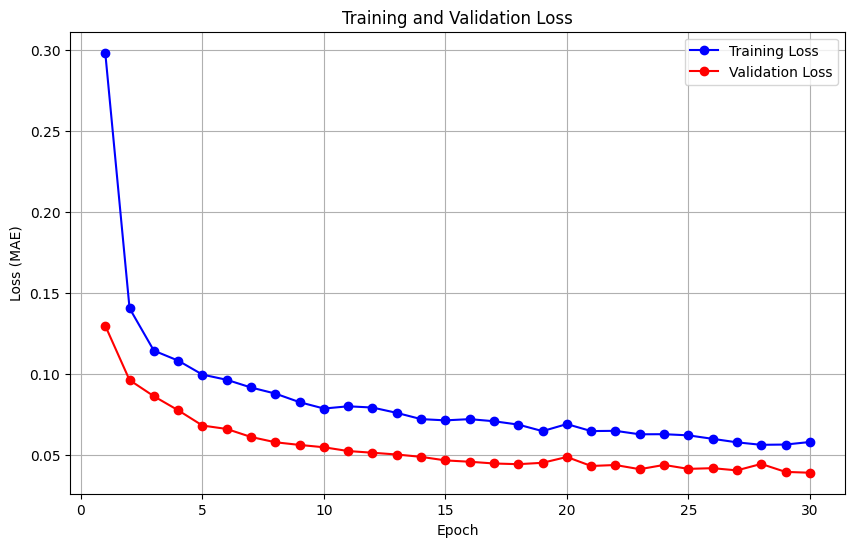

17/17 [==============================] - 42s 2s/step - loss: 0.0580 - val_loss: 0.0390


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Định nghĩa mô hình (3D CNN + GRU)
def build_model():
    # 1️⃣ Image input
    image_input = layers.Input(shape=(SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS_4))
    x = layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu')(image_input)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.Reshape((-1, x.shape[2] * x.shape[3] * x.shape[4]))(x)
    x = layers.GRU(128, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)

    # 2️⃣ P_uoc input
    power_input = layers.Input(shape=(SEQ_LENGTH,))
    p = layers.Dense(64, activation='relu')(power_input)
    p = layers.Dropout(0.3)(p)

    # 3️⃣ Time features input
    time_input = layers.Input(shape=(SEQ_LENGTH, 8))
    t = layers.Bidirectional(layers.LSTM(32))(time_input)
    t = layers.Dropout(0.3)(t)

    # 4️⃣ Combine all
    combined = layers.Concatenate()([x, p, t])
    output = layers.Dense(PRED_LENGTH, activation='linear')(combined)

    model = models.Model(inputs=[image_input, power_input, time_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
    return model


# Callback để vẽ đồ thị theo thời gian thực trong Jupyter Notebook
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.epochs = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.epochs.append(epoch + 1)
        self.losses.append(logs.get('loss', 0))
        self.val_losses.append(logs.get('val_loss', 0))  # Tránh lỗi nếu không có val_loss
        
        clear_output(wait=True)  # Xóa biểu đồ cũ để vẽ lại
        plt.figure(figsize=(10, 6))
        plt.plot(self.epochs, self.losses, 'bo-', label='Training Loss')
        if any(self.val_losses):
            plt.plot(self.epochs, self.val_losses, 'ro-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MAE)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Tạo mô hình
model = build_model()

# Chia dataset thành train và validation
def split_dataset(dataset, valid_sequences_times, split_ratio=0.8):
    print("\n🔄 Đang chia dataset thành train và validation...")
    dataset_list = list(dataset.unbatch())
    train_size = int(len(dataset_list) * split_ratio)

    train_data = dataset_list[:train_size]
    val_data = dataset_list[train_size:]

    def create_tf_dataset(data):
        return tf.data.Dataset.from_generator(
            lambda: (((img, p, tf), y) for (img, p, tf), y in data),
            output_signature=(
                (
                    tf.TensorSpec(shape=(SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS_4), dtype=tf.float32),
                    tf.TensorSpec(shape=(SEQ_LENGTH,), dtype=tf.float32),
                    tf.TensorSpec(shape=(SEQ_LENGTH, 8), dtype=tf.float32)
                ),
                tf.TensorSpec(shape=(PRED_LENGTH,), dtype=tf.float32)
            )
        ).batch(BATCH_SIZE)

    train_dataset = create_tf_dataset(train_data)
    val_dataset = create_tf_dataset(val_data)

    print(f"✅ Đã chia dataset: {len(train_data)} mẫu train, {len(val_data)} mẫu validation")
    return train_dataset, val_dataset

# Giả định dataset và valid_sequences_times đã được tạo từ Cell trước
train_dataset, val_dataset = split_dataset(dataset, valid_sequences_times, split_ratio=0.8)

# Huấn luyện mô hình với callback mới
plot_losses = PlotLosses()
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[plot_losses],
    verbose=1

)
# Lưu model để sử dụng sau này
model.save("models/final_model.h5")

In [ ]:
# # %% Cell 6: Tạo và huấn luyện mô hình
# def build_model():
#     image_input = layers.Input(shape=(SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS))
#     x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(image_input)
#     x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
#     x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
#     x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
#     x = layers.TimeDistributed(layers.Flatten())(x)
#     x = layers.LSTM(128, return_sequences=False)(x)
    
#     power_input = layers.Input(shape=(SEQ_LENGTH,))
#     p = layers.RepeatVector(SEQ_LENGTH)(power_input)
#     p = layers.LSTM(64)(p)
    
#     combined = layers.Concatenate()([x, p])
#     output = layers.Dense(PRED_LENGTH)(combined)
    
#     model = models.Model(inputs=[image_input, power_input], outputs=output)
#     model.compile(optimizer='adam', loss='mae')
#     return model

# # Tạo mô hình
# model = build_model()
# model.summary()

# # Chia dataset thành train và validation
# def split_dataset(dataset, valid_sequences_times, split_ratio=0.8):
#     print("\n🔄 Đang chia dataset thành train và validation...")
#     dataset_size = len(valid_sequences_times)
#     train_size = int(dataset_size * split_ratio)
    
#     # Chuyển dataset thành list để chia
#     dataset_list = list(dataset.unbatch())
#     train_data = dataset_list[:train_size]
#     val_data = dataset_list[train_size:]
    
#     # Tạo lại dataset từ list
#     train_dataset = tf.data.Dataset.from_generator(
#         lambda: (((img, p), t) for (img, p), t in train_data),
#         output_signature=(
#             (
#                 tf.TensorSpec(shape=(SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS), dtype=tf.float32),
#                 tf.TensorSpec(shape=(SEQ_LENGTH,), dtype=tf.float32)
#             ),
#             tf.TensorSpec(shape=(PRED_LENGTH,), dtype=tf.float32)
#         )
#     ).batch(BATCH_SIZE)
    
#     val_dataset = tf.data.Dataset.from_generator(
#         lambda: (((img, p), t) for (img, p), t in val_data),
#         output_signature=(
#             (
#                 tf.TensorSpec(shape=(SEQ_LENGTH, IMG_SIZE_MODEL[0], IMG_SIZE_MODEL[1], NUM_CHANNELS), dtype=tf.float32),
#                 tf.TensorSpec(shape=(SEQ_LENGTH,), dtype=tf.float32)
#             ),
#             tf.TensorSpec(shape=(PRED_LENGTH,), dtype=tf.float32)
#         )
#     ).batch(BATCH_SIZE)
    
#     print(f"✅ Đã chia dataset: {len(train_data)} mẫu train, {len(val_data)} mẫu validation")
#     return train_dataset, val_dataset

# # Giả định dataset và valid_sequences_times đã được tạo từ Cell 5
# train_dataset, val_dataset = split_dataset(dataset, valid_sequences_times, split_ratio=0.8)

# # Huấn luyện mô hình với validation
# history = model.fit(
#     train_dataset,
#     epochs=30,
#     validation_data=val_dataset,
#     verbose=1
# )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 6, 32, 32, 16)]      0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 6, 32, 32, 32)        4640      ['input_3[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 6, 16, 16, 32)        0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                            

InvalidArgumentError: Graph execution error:

TypeError: `generator` yielded an element of shape (6, 32, 32, 4) where an element of shape (6, 32, 32, 16) was expected.
Traceback (most recent call last):

  File "c:\Khue\H9_Solar_Power_Forecasting\.venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    ret = func(*args)

  File "c:\Khue\H9_Solar_Power_Forecasting\.venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "c:\Khue\H9_Solar_Power_Forecasting\.venv\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (6, 32, 32, 4) where an element of shape (6, 32, 32, 16) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_13206]

In [15]:
from tensorflow.keras.models import load_model
import os

# Đảm bảo file tồn tại
model_path = "models/final_model.h5"
if os.path.exists(model_path):
    model = load_model(model_path)
    print("✅ Đã load mô hình từ file:", model_path)
else:
    raise FileNotFoundError(f"❌ Không tìm thấy file mô hình tại: {model_path}")

✅ Đã load mô hình từ file: models/final_model.h5


In [19]:
# %% Cell 7: Dự đoán và vẽ dữ liệu
import plotly.graph_objects as go
import pandas as pd

def plot_predictions(model, scaler, start_date, end_date, channels=CHANNELS):
    power_df_plot, power_lookup_plot, scaler = query_power_data(
        start_date - TIME_STEP * SEQ_LENGTH,
        end_date + TIME_STEP * PRED_LENGTH
    )
    sequences_images_plot, sequences_times_plot = preprocess_images_from_folder(OUTPUT_DIR, start_date, end_date, channels)
    if sequences_images_plot.size == 0:
        print("⚠️ Không có dữ liệu ảnh để vẽ!")
        return

    dataset_plot, valid_sequences_times_plot, targets_normalized = prepare_dataset(
        sequences_images_plot, sequences_times_plot, power_lookup_plot, scaler
    )
    if not valid_sequences_times_plot:
        print("⚠️ Không có dữ liệu hợp lệ để vẽ!")
        return

    # Dự đoán
    predictions_normalized = model.predict(dataset_plot)
    predictions = scaler.inverse_transform(predictions_normalized)
    true_values = scaler.inverse_transform(np.array(targets_normalized))

    # Tạo thời gian
    num_steps = int((end_date - start_date).total_seconds() / 600) + PRED_LENGTH + 1
    full_times = pd.date_range(start=start_date + UTC_OFFSET, periods=num_steps, freq='10min')

    # Mảng dự đoán và thực tế
    full_true_step1 = np.full(len(full_times), np.nan)
    full_pred_step1 = np.full(len(full_times), np.nan)
    full_true_step3 = np.full(len(full_times), np.nan)
    full_pred_step3 = np.full(len(full_times), np.nan)
    full_true_step6 = np.full(len(full_times), np.nan)
    full_pred_step6 = np.full(len(full_times), np.nan)
    full_true_step24 = np.full(len(full_times), np.nan)
    full_pred_step24 = np.full(len(full_times), np.nan)

    for i, t in enumerate(valid_sequences_times_plot):
        base_idx = int((t - (start_date + UTC_OFFSET)) / TIME_STEP)
        for j in range(PRED_LENGTH):
            idx = base_idx + j + 1
            if 0 <= idx < len(full_times):
                if j == 0:
                    full_true_step1[idx] = true_values[i, j]
                    full_pred_step1[idx] = predictions[i, j]
                elif j == 2 and PRED_LENGTH >= 3:
                    full_true_step3[idx] = true_values[i, j]
                    full_pred_step3[idx] = predictions[i, j]
                elif j == 5 and PRED_LENGTH >= 6:
                    full_true_step6[idx] = true_values[i, j]
                    full_pred_step6[idx] = predictions[i, j]
                elif j == 23 and PRED_LENGTH >= 24:
                    full_true_step24[idx] = true_values[i, j]
                    full_pred_step24[idx] = predictions[i, j]

    # Biểu đồ Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=full_times, y=full_true_step1, mode='lines', name='Thực tế (Bước 1)', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=full_times, y=full_pred_step1, mode='lines', name='Dự đoán (Bước 1)', line=dict(color='blue', dash='dash')))

    if PRED_LENGTH >= 3:
        fig.add_trace(go.Scatter(x=full_times, y=full_true_step3, mode='lines', name='Thực tế (Bước 3)', line=dict(color='orange')))
        fig.add_trace(go.Scatter(x=full_times, y=full_pred_step3, mode='lines', name='Dự đoán (Bước 3)', line=dict(color='orange', dash='dash')))

    if PRED_LENGTH >= 6:
        fig.add_trace(go.Scatter(x=full_times, y=full_true_step6, mode='lines', name='Thực tế (Bước 6)', line=dict(color='red')))
        fig.add_trace(go.Scatter(x=full_times, y=full_pred_step6, mode='lines', name='Dự đoán (Bước 6)', line=dict(color='red', dash='dash')))

    if PRED_LENGTH >= 24:
        fig.add_trace(go.Scatter(x=full_times, y=full_true_step24, mode='lines', name='Thực tế (Bước 24)', line=dict(color='green')))
        fig.add_trace(go.Scatter(x=full_times, y=full_pred_step24, mode='lines', name='Dự đoán (Bước 24)', line=dict(color='green', dash='dash')))

    fig.update_layout(
        title=f"So sánh thực tế và dự đoán từ {start_date.strftime('%d/%m/%Y')} đến {end_date.strftime('%d/%m/%Y')}",
        xaxis_title="Thời gian",
        yaxis_title="Công suất (kW)",
        legend_title="Chú thích",
        height=600
    )
    fig.show()

    return predictions, power_df_plot, full_times


predictions, power_df_plot, full_times = plot_predictions(
    model, scaler, PLOT_START, PLOT_END, channels=CHANNELS_4)


🔄 Đang load dữ liệu công suất...
✅ Đã load 1152 bản ghi
Dữ liệu mẫu:                  Time  Month_sin  Month_cos   Day_sin   Day_cos  Hour_sin  \
0 2025-01-02 00:00:00        0.5   0.866025  0.394356  0.918958       0.0   
1 2025-01-02 00:10:00        0.5   0.866025  0.394356  0.918958       0.0   
2 2025-01-02 00:20:00        0.5   0.866025  0.394356  0.918958       0.0   
3 2025-01-02 00:30:00        0.5   0.866025  0.394356  0.918958       0.0   
4 2025-01-02 00:40:00        0.5   0.866025  0.394356  0.918958       0.0   

   Hour_cos    Minute_sin  Minute_cos  P_uoc  
0       1.0  0.000000e+00         1.0    0.0  
1       1.0  8.660254e-01         0.5    0.0  
2       1.0  8.660254e-01        -0.5    0.0  
3       1.0  5.665539e-16        -1.0    0.0  
4       1.0 -8.660254e-01        -0.5    0.0  
Lookup mẫu: {'2025-01-02 00:00': {'Month_sin': 0.49999999999999994, 'Month_cos': 0.8660254037844387, 'Day_sin': 0.39435585511331855, 'Day_cos': 0.9189578116202306, 'Hour_sin': 0.0, 'Hour

In [26]:
# %% Cell 7: Dự đoán và vẽ dữ liệu
def plot_predictions(model, scaler, start_date, end_date, channels=CHANNELS):
    power_df_plot, power_lookup_plot, scaler = query_power_data(start_date - TIME_STEP * SEQ_LENGTH, end_date + TIME_STEP * PRED_LENGTH)
    sequences_images_plot, sequences_times_plot = preprocess_images_from_folder(OUTPUT_DIR, start_date, end_date, channels)
    if sequences_images_plot.size == 0:
        print("⚠️ Không có dữ liệu ảnh để vẽ!")
        return
    
    dataset_plot, valid_sequences_times_plot, targets_normalized = prepare_dataset(sequences_images_plot, sequences_times_plot, power_lookup_plot, scaler)
    if not valid_sequences_times_plot:
        print("⚠️ Không có dữ liệu hợp lệ để vẽ!")
        return
    
    predictions_normalized = model.predict(dataset_plot)
    predictions = scaler.inverse_transform(predictions_normalized)
    true_values = scaler.inverse_transform(np.array(targets_normalized))
    
    full_times = [start_date + UTC_OFFSET + i * TIME_STEP for i in range(int((end_date - start_date).total_seconds() / 600) + PRED_LENGTH + 1)]
    
    full_true_step1 = np.full(len(full_times), np.nan)
    full_pred_step1 = np.full(len(full_times), np.nan)
    full_true_step6 = np.full(len(full_times), np.nan)
    full_pred_step6 = np.full(len(full_times), np.nan)
    full_true_step24 = np.full(len(full_times), np.nan)
    full_pred_step24 = np.full(len(full_times), np.nan)
    
    for i, t in enumerate(valid_sequences_times_plot):
        base_idx = int((t - (start_date + UTC_OFFSET)) / TIME_STEP)
        for j in range(PRED_LENGTH):
            idx = base_idx + j + 1
            if 0 <= idx < len(full_times):
                if j == 0:
                    full_true_step1[idx] = true_values[i, j]
                    full_pred_step1[idx] = predictions[i, j]
                elif j == 5:
                    full_true_step6[idx] = true_values[i, j]
                    full_pred_step6[idx] = predictions[i, j]
                elif j == 23:
                    full_true_step24[idx] = true_values[i, j]
                    full_pred_step24[idx] = predictions[i, j]
    
    plt.figure(figsize=(20, 8))
    plt.plot(full_times, full_true_step1, label='Thực tế (Bước 1)', color='blue')
    plt.plot(full_times, full_pred_step1, label='Dự đoán (Bước 1)', color='blue', linestyle='--')
    plt.plot(full_times, full_true_step6, label='Thực tế (Bước 6)', color='red')
    plt.plot(full_times, full_pred_step6, label='Dự đoán (Bước 6)', color='red', linestyle='--')
    plt.plot(full_times, full_true_step24, label='Thực tế (Bước 24)', color='green')
    plt.plot(full_times, full_pred_step24, label='Dự đoán (Bước 24)', color='green', linestyle='--')
    
    plt.xlabel('Thời gian')
    plt.ylabel('Công suất (kW)')
    plt.title(f'So sánh thực tế và dự đoán từ {start_date.strftime("%d/%m/%Y")} đến {end_date.strftime("%d/%m/%Y")}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlim(start_date + UTC_OFFSET, end_date + UTC_OFFSET + TIME_STEP * PRED_LENGTH)
    plt.tight_layout()
    plt.show()

    return predictions, power_df_plot, full_times
predictions, power_df_plot, full_times = plot_predictions(model, scaler, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 1, 1))

🔄 Đang load dữ liệu công suất...
✅ Đã load 144 bản ghi
Dữ liệu mẫu:                  Time  P_uoc
0 2024-12-31 00:00:00    0.0
1 2024-12-31 00:10:00    0.0
2 2024-12-31 00:20:00    0.0
3 2024-12-31 00:30:00    0.0
4 2024-12-31 00:40:00    0.0
Lookup mẫu: {Timestamp('2024-12-31 00:00:00'): 0.0, Timestamp('2024-12-31 00:10:00'): 0.0, Timestamp('2024-12-31 00:20:00'): 0.0, Timestamp('2024-12-31 00:30:00'): 0.0, Timestamp('2024-12-31 00:40:00'): 0.0}

🔄 Đang load ảnh từ C:\Khue\H9_Solar_Power_Forecasting\references\image_out và tạo chuỗi dữ liệu...
📊 Tìm thấy 1 thời điểm từ 2025-01-01 đến 2025-01-01
Thời gian đầu: 2025-01-01 00:00
Thời gian cuối: 2025-01-01 00:00
⚠️ Số thời điểm (1) ít hơn SEQ_LENGTH (6), không thể tạo chuỗi!
⚠️ Không có dữ liệu ảnh để vẽ!


TypeError: cannot unpack non-iterable NoneType object

In [10]:
power_df_plot

In [11]:
# Vẽ power_df_plot
plt.figure(figsize=(20, 8))
plt.plot(power_df_plot['Time'], power_df_plot['P_uoc'], label='Thực tế', color='blue')
# plt.plot(full_times, predictions.flatten(), label='Dự đoán', color='red', linestyle='--')
plt.xlabel('Thời gian')
# plt.ylabel('Công suất (kW)')
plt.title(f'So sánh thực tế và dự đoán từ {PLOT_START.strftime("%d/%m/%Y")} đến {PLOT_END.strftime("%d/%m/%Y")}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_pred = pd.DataFrame(predictions, columns=[f"Step_{i+1}" for i in range(PRED_LENGTH)])
# Vẽ df_pred cột step 1 và step 24
plt.figure(figsize=(20, 8))
plt.plot(df_pred["Step_1"], label='Dự đoán (Bước 1)', color='blue')
# plt.plot(df_pred["Step_24"], label='Dự đoán (Bước 24)', color='green')
plt.xlabel('Thời gian')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(df_pred["Step_24"], label='Dự đoán (Bước 24)', color='green')
plt.xlabel('Thời gian')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()